## The impact of `rate0` on peg


```python
rate = rate0 * exp(depeg / sigma) * exp(- pegkeeper_filling / (total_debt * target_f))
```


In [1]:
from collections import defaultdict
from copy import deepcopy
import crvusdsim
from crvusdsim.pool import copy_sim_market
import numpy as np
import pandas as pd

In [2]:
market_name = "wstETH"
(
    pool,
    controller,
    collateral_token,
    stablecoin,
    aggregator,
    stableswap_pools,
    peg_keepers,
    policy,
    factory,
) = crvusdsim.pool.get(market_name)

In [22]:

class LoanUser:
    def __init__(
        self,
        address,
        controller,
        stableswap_pools,
        collateral_amount=10 * 10**18,
        N=10,
        max_interest_ratio=0.10,
    ):
        self.address = address
        self.controller = controller
        self.borrowed_token = self.controller.STABLECOIN
        self.collateral_token = controller.COLLATERAL_TOKEN
        self.stableswap_pools = stableswap_pools
        self.collateral_amount = collateral_amount
        self.N = N
        self.max_interest_ratio = max_interest_ratio

        self.initial_debt = int(controller.max_borrowable(collateral_amount, N) * 0.90)
        self.has_debt = False
        self.interest_cost = 0  # interest cost
        self.create_loan_timestamp = 0
        self.interest_avg_ratio = 0

    def update(self, annualized_rate):
        if annualized_rate < self.max_interest_ratio:
            if not self.has_debt:
                self.create_loan_and_exchange()
        else:
            if self.has_debt:
                self.repay()

    def create_loan_and_exchange(self):
        self.collateral_token._mint(self.address, self.collateral_amount)
        self.controller.create_loan(
            self.address, self.collateral_amount, self.initial_debt, self.N
        )
        self.initial_debt = self.controller.debt(self.address)
        # choose one stableswap add liquidity (only crvUSD)
        min_balance = None
        pool_i = 0
        for i in range(len(self.stableswap_pools)):
            spool = self.stableswap_pools[i]
            _b = spool.balances[1]
            if min_balance is None or _b < min_balance:
                min_balance = _b
                pool_i = i

        add_amount = self.borrowed_token.balanceOf[self.address]
        spool = self.stableswap_pools[pool_i]
        spool.exchange(1, 0, add_amount, _receiver=self.address)
        self.create_loan_timestamp = self.controller._block_timestamp
        self.has_debt = True
        # print("create_loan_and_exchange add_amount", add_amount / 1e18)


    def repay(self):
        if not self.has_debt:
            return

        repay_amount = self.controller.debt(self.address)
        
        if repay_amount < 10**6:
            self.has_debt = False
            return            

        # choose one stableswap buy crvUSD
        buy_amount = repay_amount - self.borrowed_token.balanceOf[self.address]
        if buy_amount > 0:
            amount_in = None
            pool_i = 0
            for i in range(len(self.stableswap_pools)):
                spool = self.stableswap_pools[i]
                dx = spool.get_dx(0, 1, buy_amount)
                if amount_in is None or dx < amount_in:
                    amount_in = dx
                    pool_i = i

            amount_in += 1
            spool = self.stableswap_pools[pool_i]
            spool.coins[0]._mint(self.address, amount_in)
            spool.exchange(0, 1, amount_in, _receiver=self.address)

        # repay to controller
        self.controller.repay(repay_amount, self.address)

        if self.controller.debt(self.address) < 10**6:
            self.has_debt = False
            self.interest_cost += self.get_interest_cost()


    def get_interest_cost(self):
        # already repayed all debt
        if not self.has_debt:
            return self.interest_cost
        cur_debt = self.controller.debt(self.address)
        if cur_debt < 10**6:
            return self.interest_cost
        return cur_debt - self.initial_debt

    def interest_cost_ratio(self):
        return self.get_interest_cost() / self.initial_debt

    # avg interest cost per second
    def get_inerest_avg_cost(self):
        delta_t = self.controller._block_timestamp - self.create_loan_timestamp
        if delta_t == 0:
            return 0
        interest_cost = self.get_interest_cost()
        return interest_cost / delta_t


class Market:
    def __init__(
        self,
        pool,
        controller,
        collateral_token,
        stablecoin,
        aggregator,
        stableswap_pools,
        peg_keepers,
        policy,
        factory,
    ) -> None:
        (
            new_pool,
            new_controller,
            new_collateral_token,
            new_stablecoin,
            new_aggregator,
            new_stableswap_pools,
            new_peg_keepers,
            new_policy,
            new_factory,
        ) = copy_sim_market(
            pool,
            controller,
            collateral_token,
            stablecoin,
            aggregator,
            stableswap_pools,
            peg_keepers,
            policy,
            factory,
        )

        # reset stableswap pool balances
        for pool in new_stableswap_pools:
            s = 0
            for i in range(len(pool.balances)):
                s += pool.balances[i] * pool.rates[i] // 10**18
            for i in range(len(pool.balances)):
                balance = s // 2 * 10**18 // pool.rates[i]
                pool.balances[i] = balance
                pool.coins[i].balanceOf[pool.address] = balance

        self.pool = new_pool
        self.controller = new_controller
        self.collateral_token = new_collateral_token
        self.stablecoin = new_stablecoin
        self.aggregator = new_aggregator
        self.stableswap_pools = new_stableswap_pools
        self.peg_keepers = new_peg_keepers
        self.policy = new_policy
        self.factory = new_factory

        self.users = []
        self.total_debt = 0
        self.state_logs = []
        self.initial_collateral = 0
        self.max_annualized_rate = 0.22
        self.duration = 0
        self.params = {}

    def init(self, rate0, sigma, target_f, max_annualized_rate):
        self.params = {
            "rate0": rate0,
            "sigma": sigma,
            "target_f": target_f,
        }
        self.max_annualized_rate = max_annualized_rate
        # The rate0 in the code will convert the annualized rate to the rate per second
        self.policy.rate0 = int(((1 + rate0) ** (1 / (365 * 86400)) - 1) * 1e18)
        self.policy.sigma = int(sigma * 10**18)
        self.policy.target_debt_fraction = int(target_f * 10**18)

        # Assume users will `create_loan` if annualized rate 
        # lower than `max_annualized_rate`
        users_count = 80
        users_address = ["user_address_%d" % i for i in range(users_count)]
        collateral_price = self.pool.get_p() / 1e18
        self.initial_collateral = sum([sum(spool.balances) for spool in self.stableswap_pools]) / collateral_price * 0.01 // users_count

        for i in range(users_count):
            user = LoanUser(
                 "init_user_address_%d" % i,
                self.controller,
                self.stableswap_pools,
                collateral_amount=self.initial_collateral,
            )
            user.create_loan_and_exchange()
            self.users.append(user)

        annualized_rate = self.get_annualized_rate()
        self.total_debt = self.controller.total_debt()
        rate_mul = self.controller._rate_mul_w()

        print("init collateral_amount", self.initial_collateral / 1e18, "annualized_rate", annualized_rate)

    def _increment_blockts(self, delta_t):
        self.pool._increment_timestamp(timedelta=delta_t)
        self.pool.price_oracle_contract._increment_timestamp(timedelta=delta_t)
        self.controller._increment_timestamp(timedelta=delta_t)
        self.aggregator._increment_timestamp(timedelta=delta_t)
        for pk in self.peg_keepers:
            pk._increment_timestamp(timedelta=delta_t)
        for stablepool in self.stableswap_pools:
            stablepool._increment_timestamp(timedelta=delta_t)
    
    def get_annualized_rate(self):
        return (1 + self.policy.rate(self.controller) / 1e18) ** (365 * 86400) - 1

    def adjust_crvusd_price(self, p):
        old_agg_p = self.aggregator.price()
        diff = abs(old_agg_p - p) / old_agg_p
        divider = 100
        if diff < 0.001:
            divider = 1000

        for spool in self.stableswap_pools:
            cur_p = spool.price_oracle()
            if cur_p > p:
                size = spool.balances[1] // divider
                while spool.price_oracle() > p:
                    spool.trade(1, 0, size)
                    # update price_oracle
                    spool.ma_price = spool.last_price
            else:
                size = spool.balances[0] // divider
                while spool.price_oracle() < p:
                    spool.trade(0, 1, size)
                    # update price_oracle
                    spool.ma_price = spool.last_price

        new_agg_p = self.aggregator.price()
        assert abs(new_agg_p / p) - 1 < 1e-3

        # update rate
        rate_mul = self.controller._rate_mul_w()

    def process_by_dt(self, dt):
        self._increment_blockts(delta_t=dt)
        self.controller._rate_mul_w()

        annualized_rate = self.get_annualized_rate()

        if annualized_rate < self.max_annualized_rate:
            user = LoanUser(
                "user_address_%d" % (self.controller._block_timestamp),
                self.controller,
                self.stableswap_pools,
                collateral_amount=self.initial_collateral,
            )
            user.create_loan_and_exchange()
            self.users.append(user)
        
        else:
            if len(self.users) > 0:
                user = self.users.pop()
                user.repay()

        self.duration += dt
        self.update_log()

    def update_log(self):
        pk_debt = sum([pk.debt for pk in self.peg_keepers])
        total_debt = self.factory.total_debt()
        pegkeeper_filling = pk_debt / total_debt if total_debt > 0 else 0

        self.state_logs.append(
            {
                "timestamp": self.pool._block_timestamp,
                "duration": self.duration,
                "agg_price": self.aggregator.price() / 1e18,
                "annualized_rate": self.get_annualized_rate(),
                "pk_debt": pk_debt / 1e18,
                "total_debt": total_debt / 1e18,
                "pegkeeper_filling": pegkeeper_filling,
            }
        )

In [25]:
# rate = rate0 if PegKeepers are empty, lower when at target fraction
rate0s = [0.05, 0.10, 0.15]
depeg = 0.005  # 0.5%
sigma = 0.02  # 2%
target_f = 0.10  # target fraction 10%
# Assume annualized rate greater than `max_annualized_rate`, 
# user will repay their debt
max_annualized_rate = 0.235

def sim():

    start_agg_p = int(1 * (1 - depeg) * 10**18)
    
    markets = []
    for rate0 in rate0s:
        market = Market(
            pool,
            controller,
            collateral_token,
            stablecoin,
            aggregator,
            stableswap_pools,
            peg_keepers,
            policy,
            factory,
        )
        market.adjust_crvusd_price(start_agg_p)
        market._increment_blockts(delta_t=24 * 60 * 60) # wait oracle price update
        market.init(rate0, sigma, target_f, max_annualized_rate)
        market.update_log()
        markets.append(market)

    dt_interval = 10 # seconds
    sim_count = 1 * 24 * 60 * 60 // dt_interval
    for i in range(sim_count):
        for m in markets:
            m.process_by_dt(dt=dt_interval)
    
    
    return markets

markets = sim()

init collateral_amount 3.4645765270461593 annualized_rate 0.0657174257103097
init collateral_amount 3.4645765270461593 annualized_rate 0.1323951003930579
init collateral_amount 3.4645765270461593 annualized_rate 0.20000243041340826


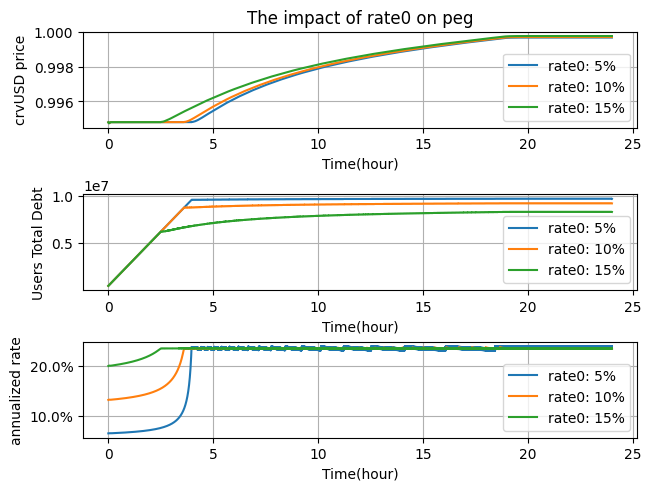

<Figure size 1200x1200 with 0 Axes>

In [29]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained')

time_series = [log["duration"] / (1 * 60 * 60) for log in markets[0].state_logs]

for m in markets:
    label = "rate0: %.0f%%" % (m.params["rate0"] * 100)
    agg_p = [log["agg_price"] for log in m.state_logs]
    total_debt = [log["total_debt"] for log in m.state_logs]
    rates_list = [log["annualized_rate"] for log in m.state_logs]

    ax1.plot(time_series, agg_p, label=label, antialiased=True)
    ax2.plot(time_series, total_debt, label=label)
    ax3.plot(time_series, rates_list, label=label)


ax1.set_title("The impact of rate0 on peg")
ax1.set_xlabel('Time(hour)')
ax1.set_ylabel('crvUSD price')
ax1.grid(True)
ax1.legend(loc='lower right')


ax2.set_xlabel('Time(hour)')
ax2.set_ylabel('Users Total Debt')
ax2.grid(True)
ax2.legend(loc='lower right')

ax3.set_xlabel('Time(hour)')
ax3.set_ylabel('annualized rate')
ax3.grid(True)
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax3.legend(loc='lower right')

plt.figure(figsize=(12,12))
plt.show()
